In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data

In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 'data/main_fmri_study/derivatives/ppi')
path_networks = os.path.join(path_out, 'networks')
path_parcellations = os.path.join(path_out, 'parcellations')
path_300_roi = os.path.join(path_parcellations, '300_ROI_Set/ROIs_300inVol_MNI_allInfo.txt')
df_atlas = pd.read_csv(path_300_roi, sep=' ')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh, verbose=True)
n_subjects, n_conditions, n_trials, _ = beh.shape
n_rois = 300

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


In [3]:
labels = df_atlas['netName']

new_index = []
for label in labels.unique():
    new_index += list(labels[labels==label].index)
    
df_atlas = df_atlas.reindex(new_index)
df_atlas['netName'] = df_atlas['netName'].astype('category')
df_atlas = df_atlas.reset_index()

In [4]:
corr_mat_all = np.zeros((n_subjects, n_conditions, n_rois, n_rois))

for sub, sub_name in enumerate(meta['dim1']):
    for con, con_name in enumerate(meta['dim2']):
        fname = f'sub-{sub_name}_task-{con_name}_corrmat-ppiperrfull.npy'
        corr_mat = np.load(os.path.join(path_networks, fname))
        corr_mat = corr_mat[new_index][new_index]
        corr_mat_all[sub, con] = (corr_mat + corr_mat.T) / 2
        
corr_mat_mean = np.mean(corr_mat_all, axis=0)

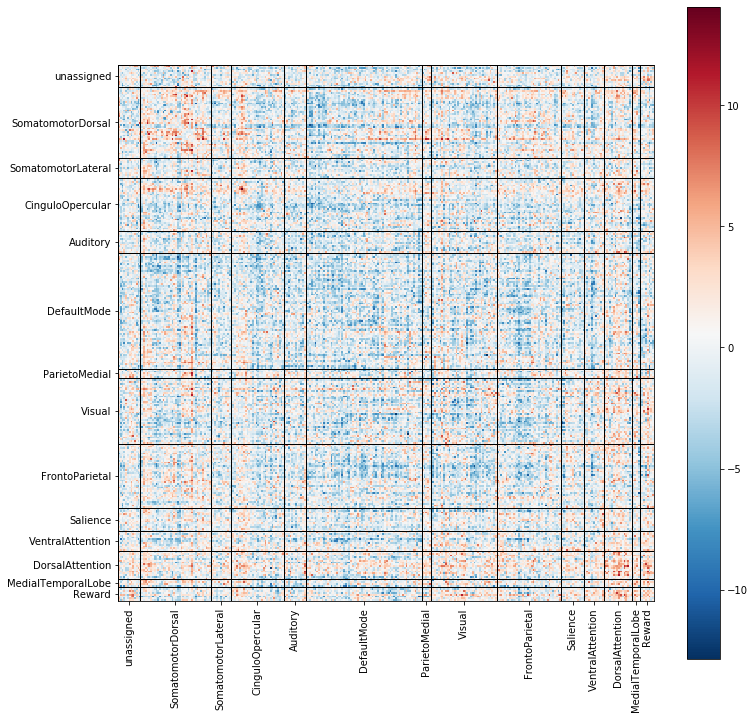

In [6]:
fig, ax = plt.subplots(figsize=(12, 12), facecolor='w')
im = ax.imshow(corr_mat_mean[0], 'RdBu_r', origin='upper')

boundaries = df_atlas['netName'].cat.codes.diff() != 0
boundaries = np.array(boundaries[boundaries].index) - .5
boundaries = np.append(boundaries, [n_rois - .5])
tick_positions = [(b1+b2)/2 for b1, b2 in zip(boundaries, boundaries[1:])] 

for boundary in boundaries:
    ax.axvline(x=boundary, color='k', linewidth=1)
    ax.axhline(y=boundary, color='k', linewidth=1)
    
ax.set_xticks(tick_positions)
ax.set_yticks(tick_positions)
ax.set_xticklabels(df_atlas['netName'].unique(), rotation=90)
ax.set_yticklabels(df_atlas['netName'].unique())

plt.colorbar(im)
plt.show()